# <center>Lab Three Association Rule Mining, Clustering, or Collaborative Filtering</center>
<center><font size = "4"> Australian Weather Station Collection Data 2007-2017</font></center>

##### <center>Create by An Nguyen, Andy Ho, Jodi Pafford</center>
<center> April 14, 2019</center>

# Total Points

# Business Understanding
<b>Describe the purpose of the data set you selected (i.e.,why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?</b>



This project is based off of a rainfal prediction dataset from Australia. The original data file named 'weatherAus.csv' was outputted as 'rainfall.csv' after our pre-processing.  The data set contains daily weather observations from numerous Australian weather stations.  The daily observations are available from http://www.bom.gov.au/climate/data. Copyright Commonwealth of Australia 2010, Bureau of Meteorology.  

The following is the data meaning types for the features used for Lab Two (19 variables by class type):

- Int64: RainToday, RainTomorrow
- Float64: MinTemp, MaxTemp, Rainfall, WindGustDir, WindGustSpeed, WindDir9am, WindDir3pm, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Cloud9am, Cloud3pm, Temp9am, Temp3pm

Codebook in its entirety can be found at https://www.kaggle.com/jsphyg/weather-dataset-rattle-package.

The original data set had 140,787 observations and 24 features.  After pre-processing, dimension reduction occurred leaving the new data set at 101,328 observations and 19 features.  Observations were removed if it contained any NaNs within its features.  The following features were removed:

- Evaporation : Too many NaNs to impute
- Sunshine: Too many NaNs to impute
- Date: Feature not required for classification and/or prediction
- Location: Feature not required since we're predicting rain or not for Australia and not by cities
- RISK_MM: Feature not required since it measures the amount of rain.  Would impact modeling results.

We also decided for classification/regression purposes, to convert the "Cardinal Directions" to degrees.  For example, N':0, 'NNE':22.5, 'NE':45, 'NE':45, and so on. 

The reduction of features will help make our proposed model simpler and mitigate the probabiilty of overfitting.  Since the data set has over a hundred thousand observations, we had sufficient number of observations that removing the observations with NaNs would not interfere with our training and test set results (i.e. accuracy).

Further modeling and various evaluations will be required to better understand which measure are most appropriate for analyzing the results of our modeling.  

This algorithm will be measured for effectiveness using a clustering algorithm in classifying rainfall throughtout Asutralia.

We will be using  The Adjsuted Rand Score (ARS) and Calinski_Harabaz for validation.  

The Rand score (RS) is measure of similarity between the predicted and true clustering.  ARS is the RS "adjusted for chance"  using this equation:

ARS = (RS - Expected_RS) / (max(RS) - Expected_RS)
    
An ARS of 0.0 indicates a random labeling of each points and a 1.0 score indicate a perfect labeling.

 Calinski-Harabaz score or the Variance Ratio Criterion.  The Calinski-Harabaz score is used when the true labels are not known.  This score is a ration between the within-cluster dispersion and the between-cluster dispersion.  The higher the score the better.

# Data Understanding 1
<b>Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.</b>

In [1]:
import seaborn
import pandas

#Assign values to response variable, y, and explanatory variables, x.
rainfall = pandas.read_csv('rainfall.csv', index_col=0) 
temp_rainfall = rainfall.copy()

# Visualising missing data:
seaborn.heatmap(temp_rainfall.isnull(),yticklabels=False,cbar=False,cmap='Reds_r')

#Variables 'Evaporation' and 'Sunshine' contained many missing values, too many to be imputed.
temp_rainfall = temp_rainfall.drop(['Evaporation', 'Sunshine'], axis = 1)

#Get name of all cities in the data frame.
l = list(temp_rainfall.Location.unique())

#Drop all observations with NaN's.  These are values that could not be imputed using the above code.
temp_rainfall.dropna(subset = list(temp_rainfall), inplace = True)

#List all cities that were dropped
for i in l:
    if i not in temp_rainfall.Location.unique():
        print(i)
        
#'Date' and 'Location' variables not needed for prediction. 
temp_rainfall = temp_rainfall.drop(['Date', 'Location'], axis = 1)

BadgerysCreek
Newcastle
NorahHead
Penrith
Tuggeranong
MountGinini
Nhil
Dartmoor
GoldCoast
Adelaide
Albany
Witchcliffe
SalmonGums
Walpole


In [2]:
temp_rainfall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101328 entries, 0 to 140786
Data columns (total 19 columns):
MinTemp          101328 non-null float64
MaxTemp          101328 non-null float64
Rainfall         101328 non-null float64
WindGustDir      101328 non-null float64
WindGustSpeed    101328 non-null float64
WindDir9am       101328 non-null float64
WindDir3pm       101328 non-null float64
WindSpeed9am     101328 non-null float64
WindSpeed3pm     101328 non-null float64
Humidity9am      101328 non-null float64
Humidity3pm      101328 non-null float64
Pressure9am      101328 non-null float64
Pressure3pm      101328 non-null float64
Cloud9am         101328 non-null float64
Cloud3pm         101328 non-null float64
Temp9am          101328 non-null float64
Temp3pm          101328 non-null float64
RainToday        101328 non-null int64
RainTomorrow     101328 non-null int64
dtypes: float64(17), int64(2)
memory usage: 15.5 MB


0    109586
1     31201
Name: RainTomorrow, dtype: int64


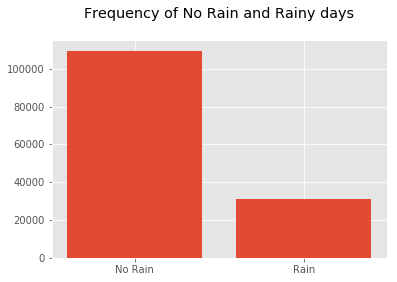

In [12]:
import matplotlib as mpl

mpl.style.use('ggplot')
plt.figure(figsize=(6,4))
plt.hist(rainfall['RainTomorrow'],bins=2,rwidth=0.8)
plt.xticks([0.25,0.75],['No Rain','Rain'])
plt.title('Frequency of No Rain and Rainy days\n')
print(rainfall['RainTomorrow'].value_counts())

C:\Users\jodip\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


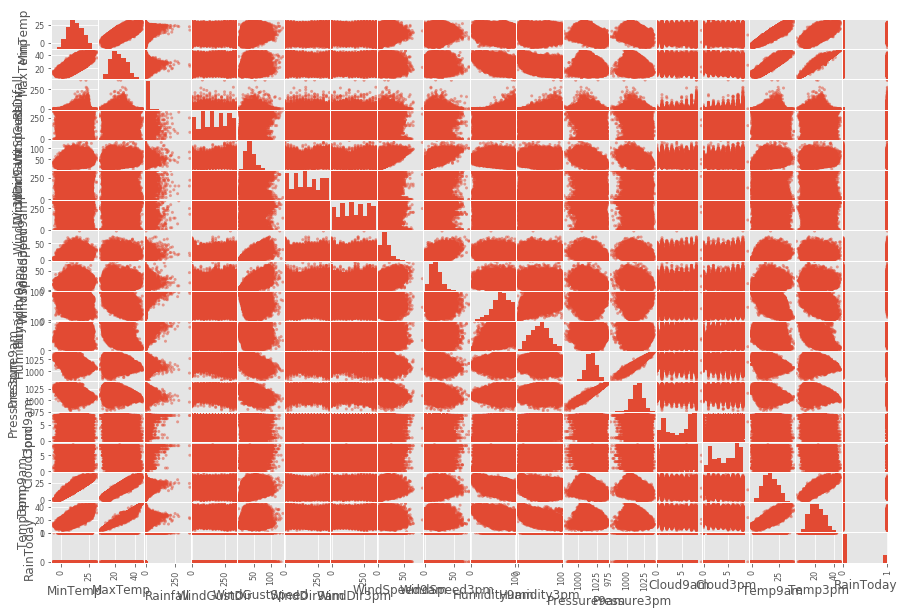

In [29]:
from pandas.tools.plotting import scatter_matrix

ax = scatter_matrix(temp_rainfall,figsize=(15, 10))

# Data Understanding 2
<b>Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertations.</b>

For the clustering task, we chose to use the F1 calculation as our evaluation metrics. The F1 measure is the weighted average of Precision and Recall. The dataset we are using is not senstive to False Positive like that of a medical study and therefore it is not as important to use Precision and Recall alone. Accuracy is not the best choice when the classes are not close to equal in sizes and therefore not a good fit for this dataset. Class size is demonstrated below. F1 Calculation, 2(Recall  Precision)/(Recall + Precision), will be used as our evaluation metric of choice.

# Modeling and Evaluation 1
<b>Train and adjust parameters.</b>

In [3]:
if 'RainTomorrow' in temp_rainfall:
    #Response variable is 'RainTomorrow'
    y = temp_rainfall['RainTomorrow'].values
    
    #Remove response variable from dataframe
    del temp_rainfall['RainTomorrow']
    
    #Everything else is the explanatory variables used in prediction.
    x = temp_rainfall.values

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
import time

def bench_k_means(estimator, name, data):
    t0 = time.time()
    y_hat=estimator.fit_predict(data)
    print(name)
    print("Adjusted Rand Score (-1 to 1): %f" %(sklearn.metrics.adjusted_rand_score(y, y_hat)))
    print("Calinski-Harabaz Score (higher scores relates to better defined clusters): %f"
          %(sklearn.metrics.calinski_harabaz_score(X=data, labels=y_hat)))
    return y_hat
    
scl_obj = StandardScaler()
scl_obj.fit(x)
x_scaled = scl_obj.transform(x)
    
bench_k_means(KMeans(init='random', n_clusters=2), name="random", data=x)
bench_k_means(KMeans(init='k-means++', n_clusters=2), name="k-means++", data=x)
bench_k_means(KMeans(init='random', n_clusters=2), name="random, scaled", data=x_scaled)
bench_k_means(KMeans(init='k-means++', n_clusters=2), name="k-means++, scaled", data=x_scaled)


random
Adjusted Rand Score (-1 to 1): 0.001697
Calinski-Harabaz Score (higher scores relates to better defined clusters): 64454.289860
k-means++
Adjusted Rand Score (-1 to 1): 0.001680
Calinski-Harabaz Score (higher scores relates to better defined clusters): 64454.287819
random, scaled
Adjusted Rand Score (-1 to 1): -0.000739
Calinski-Harabaz Score (higher scores relates to better defined clusters): 23179.849870
k-means++, scaled
Adjusted Rand Score (-1 to 1): -0.000996
Calinski-Harabaz Score (higher scores relates to better defined clusters): 23179.847024


array([0, 0, 0, ..., 1, 0, 0])

- Unscaled data resulted in a better Adjusted Rand Score and Calinski-Harabaz Score, will use this dataset to test if DBSCAN will provide a better model.

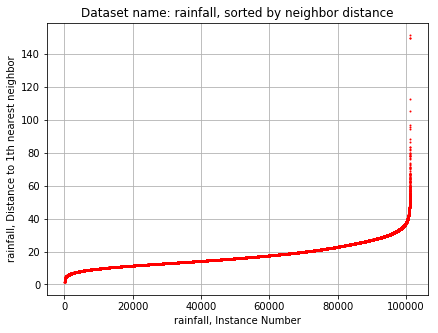

In [5]:
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import numpy

n=1 #x=1, 10, 50.  All gave the same shape, 1 was chosen because it's the least computationally expensive
X2_knn_graph = kneighbors_graph(x, n, mode='distance') # calculate distance to x nearest neighbors

N2 = X2_knn_graph.shape[0]
X2_4nn_distances = numpy.zeros((N2,1))
for i in range(N2):
    X2_4nn_distances[i] = X2_knn_graph[i,:].max()

X2_4nn_distances = numpy.sort(X2_4nn_distances, axis=0)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(N2), X2_4nn_distances, 'r.', markersize=2) #plot the data
plt.title('Dataset name: rainfall, sorted by neighbor distance')
plt.xlabel('rainfall, Instance Number')
plt.ylabel('rainfall, Distance to {0}th nearest neighbor'.format(n))
plt.grid()

In [6]:
from sklearn.cluster import DBSCAN

labels=bench_k_means(DBSCAN(eps=40, min_samples=8), name="DBSCAN", data=x) #tried min_samples = 1, 100, 50, 25, 10, 5, 8

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

DBSCAN
Adjusted Rand Score (-1 to 1): 0.039392
Calinski-Harabaz Score (higher scores relates to better defined clusters): 42.286153
Estimated number of clusters: 2


# Modeling and Evaluation 2
<b>Evaluate and Compare</b>

- Scaling the observations to their means resulted in less accuracy and cluster formations, Adjusted Rand score in the negative and Calinski-Harabaz score is 17820.4 to the 49773.9 of the un-scaled dataset.
- Using a random initilization or an initialization where the centroids' distances are maximized did not seem to have much of an effect on accuracy or cluster formation.
- DBSCAN resulted in a much lower Calinski-Harabaz score, 38.1, then KMeans, 49773.0.  Indicating that DBSCAN had less defined clusters.  
- DBSCAN's Adjusted Rand Score is much larger that of KMeans, 0.05 to 0.002.  indicating there were more similarities between the predicted clusters and the true values, better accuracy.  However, perfect accuracy is 1.0, a 0.05 is not very impressive.

# Modeling and Evaluation 3
<b>Visualize Results</b>


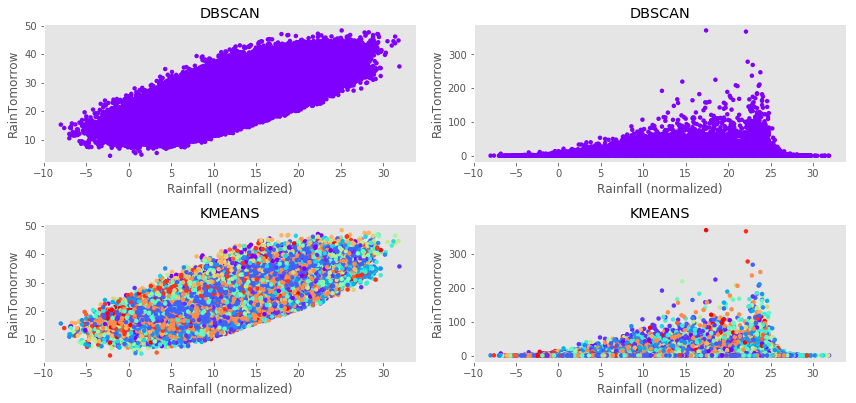

In [28]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import numpy as np

data = x

cls = DBSCAN(eps=0.125, min_samples=6)
cls.fit(data)
dbs_labels = cls.labels_ 


cls = KMeans(n_clusters=17, random_state=1)
cls.fit(data)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(12,8))
title = ['DBSCAN','KMEANS']

for i,l in enumerate([dbs_labels,kmn_labels]):
    
    plt.subplot(3,2,2*i+1)
    plt.scatter(data[:, 0], data[:, 1]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Rainfall (normalized)'), plt.ylabel('RainTomorrow')
    plt.grid()
    plt.title(title[i])
    
    plt.subplot(3,2,2*i+2)
    plt.scatter(data[:, 0], data[:, 2]+np.random.random(data[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('Rainfall (normalized)'), plt.ylabel('RainTomorrow')
    plt.grid()
    plt.title(title[i])
    
    


plt.tight_layout()
plt.show()

# Modeling and Evaluation 4
<b>Summarize the Ramifications</b>


# Deployment
<b>Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?</b>

* How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
* How would your deploy your model for interested parties?
* What other data should be collected?
* How often would the model need to be updated, etc.?

# Exceptional Work
<b>You have free reign to provide additional analyses or combine analyses</b>